# In this final movies project, I will demonstrate some ML methods. We revisit the same dataset already used in previous projects. This will highlight what machine learning methods can and cannot do  for  you,  compared  to  Hypothesis  testing  and  Prediction  methods. 

### Dataset description

This dataset features ratings data of 400 movies from 1097 research participants. 

* 1st row: Headers (Movie titles/questions) – note that the indexing in this list is from 1
* Row 2-1098: Responses from individual participants
* Columns 1-400: These columns contain the ratings for the 400 movies (0 to 4, and missing)
* Columns 401-421: These columns contain self-assessments on sensation seeking behaviors (1-5)
* Columns 422-464: These columns contain responses to personality questions (1-5)
* Columns 465-474: These columns contain self-reported movie experience ratings (1-5)
* Column 475: Gender identity (1 = female, 2 = male, 3 = self-described)
* Column 476: Only child (1 = yes, 0 = no, -1 = no response)
* Column 477: Movies are best enjoyed alone (1 = yes, 0 = no, -1 = no response)

In [1]:
from myModules import movieClass
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(style="darkgrid")

# Data preprocessing and labels
Movies = movieClass.movie(verbose=True, alpha=0.005)
usrData = pd.DataFrame(Movies.userData()).T
names = ['User ' + str(i) for i in range(len(usrData.columns))]
usrData.columns = names
data = usrData[420:474].T
factors = Movies.titles[420:474]

## PCA for Dimensionality Reduction

I apply an overall PCA to the data in columns 421-474. These columns contain self-report answers to personality and how these individuals experience  movies,  respectively. Missing data were filled with column averages as no aggressive outliers had been shifting distributions from center.

### a) Determine the number of factors (principal components). Make  a  Scree  plot.
### b) Semantically interpret what those factors represent (hint: Inspect the loadings matrix). Explicitly name the factors and decided to interpret meaningfully in a). 

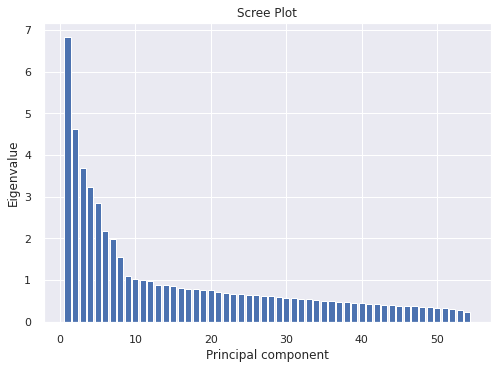

In [2]:
# Z-score the data: same as StandardScaler().fit_transform(data.values)
zscoredData = stats.zscore(data)

# Run the PCA:
pca = PCA().fit(zscoredData)

# Eigenvalues: Single vector of eigenvalues in decreasing order of magnitude
eigVals = pca.explained_variance_

# Loadings (eigenvectors): Weights per factor in terms of the original data. Where do the
# principal components point, in terms of the 54 questions?
loadings = pca.components_

# Rotated Data: Simply the transformed data - we had 1097 particpants (rows) in
# terms of 54 variables (each question is a column); now we have 1097 participants in terms of 54
# factors ordered by decreasing eigenvalue
rotatedData = pca.fit_transform(zscoredData)

fig1 = plt.figure()
numClasses = data.shape[1]
plt.bar(np.linspace(1, numClasses, numClasses), eigVals)
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.savefig("scree.png")
plt.show()


### We use Horn's method to determine the number of relevant factors to consider; here, only 8 factors were above the noise and are thus chosen. The components are listed in subplots to follow.

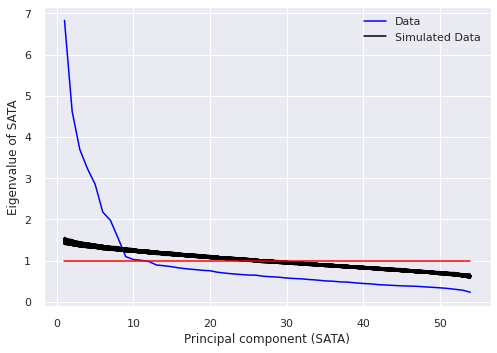

In [3]:
# Horns Method for choosng 8 factors (above noise): Simulate noise distributions to see which factors exceed
# what you would expect from noise. Resampling/Bootstrap-based. This is explained in the NDS book, in 
# the PCA chapter as described on page 239ff of the NDS book

# Initialize variables:
nDraws = 2000  # How many repetitions per resampling?
# How many rows to recreate the dimensionality of the original data?
numRows = data.shape[0]
# How many columns to recreate the dimensionality of the original data?
numColumns = data.shape[1]
# Initialize array to keep eigenvalues of sata
eigSata = np.empty([nDraws, numColumns])
eigSata[:] = np.NaN  # Convert to NaN

for i in range(nDraws):
    # Draw the sata from a normal distribution:
    sata = np.random.normal(0, 1, [numRows, numColumns])
    # Run the PCA on the sata:
    pca = PCA()
    pca.fit(sata)
    # Keep the eigenvalues:
    temp = pca.explained_variance_
    eigSata[i] = temp

# Make a plot of that and superimpose the real data on top of the sata:
plt.plot(np.linspace(1, numColumns, numColumns), eigVals,
         color='blue')  # plot eigVals from section 4
plt.plot(np.linspace(1, numColumns, numColumns),
         np.transpose(eigSata), color='black')  # plot eigSata
plt.plot([1, numColumns], [1, 1], color='red')  # Kaiser criterion line (for reference, where eigenvalues > 1)
plt.xlabel('Principal component (SATA)')
plt.ylabel('Eigenvalue of SATA')
plt.legend(['Data', 'Simulated'])
plt.savefig('horns.png')
plt.show()

### We look at loadings for all principal components to determine the greatest contributions of features (our questions) in a given direction (we use the L1 norm for eigenvectors to plot below). 

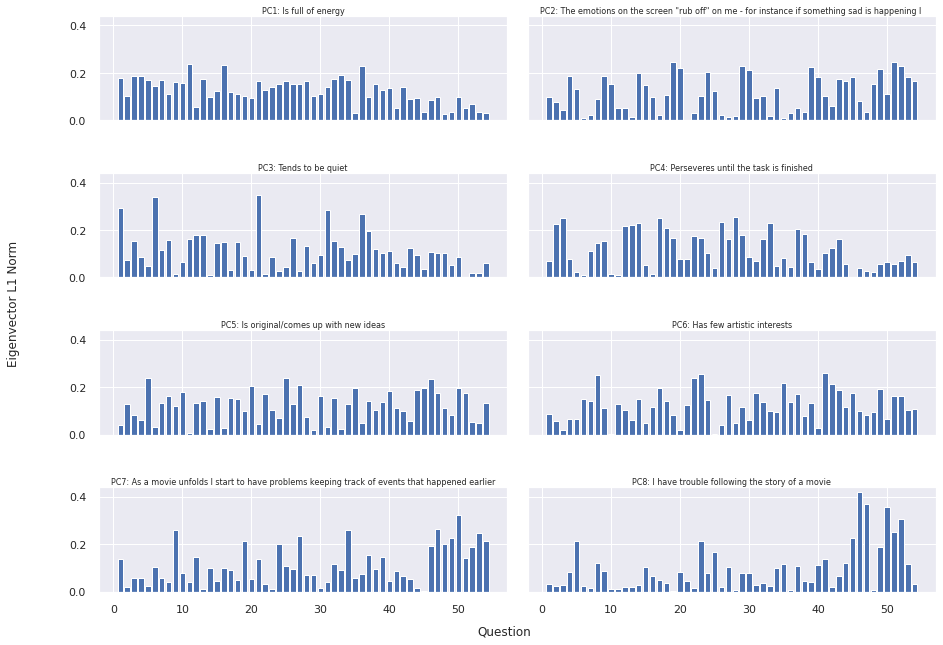

In [4]:

fig2, axs = plt.subplots(4, 2, figsize=(15, 10), sharey=True, sharex=True)
x = np.linspace(1, data.shape[1], data.shape[1])
pc = 0
for row in range(4):
    for col in range(2):
        y = np.abs(loadings[pc, :])
        axs[row, col].bar(x, y)
        title = 'PC' + str(pc+1) + ': ' + \
            str(factors[np.argmax(np.abs(loadings[pc, :]))])
        axs[row, col].set_title(title[0:95], fontdict={'fontsize': 8}, pad=2.0)
        pc += 1

plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.5)
fig2.text(0.5, 0.04, 'Question', ha='center')
fig2.text(0.04, 0.5, 'Eigenvector L1 Norm', va='center', rotation='vertical')
plt.savefig("PCnorms.png")
plt.show()

### We plot  the  data  from  columns  421-474  in  the  new  coordinate  system,  where  each  dot  represents a person,  and  the  axes  represent  the  factors  from above.

### Identify clusters in this new space. kMeans is chosen as the clustering algorithm.